In [1]:
!pip install sentence-transformers
!pip install huggingface_hub
!huggingface-cli login

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
import time
import re
from itertools import chain
from transformers import pipeline
import ast

In [3]:
EMBEDDINGS_LABEL = "embedding"
THRESHOLD = 0.6
SAMPLES_LEN = 300
TOP_MATCHES = 5

In [4]:
import requests
def get_esco_df(url):
  response = requests.get(url)
  with open("esco_embeddings.npz", "wb") as file:
    file.write(response.content)
  data = np.load("esco_embeddings.npz", allow_pickle=True)
  return pd.DataFrame({
      "label": data["label"],
      "broader": data["broader"],
      "embedding": list(data["embedding"]),
      "label_embedding": list(data["label_embedding"]),
      "cleaned_embedding": list(data["cleaned_embedding"]),
      "cleaned_label_embedding": list(data["cleaned_label_embedding"]),
  })

In [5]:
from sklearn.model_selection import train_test_split

merged_dataset_df = pd.read_csv("hf://datasets/Boanerges/multisource-esco-set/merged_dataset.csv")
train_df, test_df = train_test_split(merged_dataset_df, test_size=0.3, random_state=42)
test_df = test_df[test_df['sentence_type'] == "explicit"]
test_df = test_df[test_df['extract'] == "job"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatize and remove stopwords
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
from collections import Counter

def get_df_samples(df, samples_len=SAMPLES_LEN):
    return df.sample(n=samples_len, random_state=42)

def print_results(df):
  matched = df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)]

  def count_same_broader(skill_labels):
    if not skill_labels: return "0/0"
    broader_categories = [esco_df[esco_df["label"] == skill]["broader"].values[0] for skill in skill_labels if skill in esco_df["label"].values]

    if not broader_categories: return "0/0"

    most_common_broader = max(set(broader_categories), key=broader_categories.count)
    same_broader_count = broader_categories.count(most_common_broader)

    return f"{same_broader_count}/{len(skill_labels)}"

  def score_group(score_list):
    if not score_list: return "0%"
    max_score = max(score_list) * 100
    return f"{int(max_score // 5) * 5}%"

  matched = matched.copy()  # Ensure it’s a copy, not a view
  matched['same_broader_count'] = matched['esco'].apply(count_same_broader)
  matched['score_group'] = matched['score'].apply(score_group)

  broader_counts = Counter(matched['same_broader_count'])
  score_counts = Counter(matched['score_group'])

  print(f"{len(matched)} / {len(df)} ({len(matched) / len(df) * 100:.2f}%), ({df['esco'].apply(len).sum()})")

  # print("Same broader category counts per row:")
  # for key, value in sorted(broader_counts.items(), key=lambda x: x[0], reverse=True):
  #       print(f"{value} rows have {key} broader")

  # print("\nScore distribution for matched skills (rounded to 5%):")
  # for key, value in sorted(score_counts.items(), key=lambda x: int(x[0].replace('%', '')), reverse=True):
  #   print(f"{value} rows have scores above {key}")

In [8]:
test_samples = get_df_samples(test_df)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def find_esco_skill(input_embeddings, embeddings, threshold=THRESHOLD):
    all_skills = []
    all_scores = []
    matched_skills = []

    for embedding in input_embeddings:
      # Compute cosine similarity with all ESCO embeddings
      similarities = cosine_similarity([embedding], embeddings)[0]
      above_threshold_indices = np.where(similarities >= threshold)[0]
      matched_skills.extend([
          (esco_df.iloc[i]['label'], similarities[i]) for i in above_threshold_indices
      ])

    # Sort results by similarity score
    matched_skills.sort(key=lambda x: x[1], reverse=True)
    matched_skills = matched_skills[:TOP_MATCHES]
    all_scores.extend([score for skill, score in matched_skills if skill not in all_skills])
    all_skills.extend([skill for skill, score in matched_skills if skill not in all_skills])

    return pd.Series([all_skills, all_scores])

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def get_embeddings(x, model, tokenizer=None):
    return model.encode(x, normalize_embeddings=True, device=device)

def get_jobbert_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [11]:
res_cols = ["Precision", "Recall", "F1-score", "Threshold", "Skills-count", "Matched", "Accuracy", "Avg-Score"]
res_df = pd.DataFrame(columns=res_cols)

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(df, esco_df):
    multibinarizer = MultiLabelBinarizer(classes=list(set(esco_df["label"].explode())))

    y_true = list(df["preferredLabel"].apply(lambda x: [x]).tolist())  # Convert single label into a list
    y_pred = list(df["esco"].tolist())

    matched = len(df[df.apply(lambda row: row['preferredLabel'] in row['esco'], axis=1)])
    matched_text = f"{matched} / {SAMPLES_LEN} ({matched / SAMPLES_LEN * 100:.2f}%)"

    matched_scores = df.apply(lambda row: sum(row['score'][i] for i, skill in enumerate(row['esco']) if skill == row['preferredLabel']), axis=1)
    all_scores = df['score'].apply(sum)

    y_true = multibinarizer.fit(y_true).transform(y_true)
    y_pred = multibinarizer.transform(y_pred)

    precision = precision_score(y_true, y_pred, average="samples", zero_division=0)
    recall = recall_score(y_true, y_pred, average="samples", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="samples", zero_division=0)
    """
        TP = sum(1 for pred in predicted_labels if pred == true_label)
        precision = TP / len(predicted_labels) if predicted_labels else 0
        recall = TP / 1  # Only one correct label (preferredLabel)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    """
    avg_score = matched_scores.sum() / all_scores.sum() if all_scores.sum() > 0 else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Threshold": THRESHOLD,
        "Skills-count": df['esco'].apply(len).sum(),
        "Matched": f"{matched} / {SAMPLES_LEN}",
        "Accuracy": matched / SAMPLES_LEN,
        "Avg-Score": f"{avg_score:.4f}"
    }

In [13]:
model = SentenceTransformer('abd1987/esco-context-skill-extraction')
esco_df = get_esco_df("https://huggingface.co/datasets/abd1987/esco-embeddings-numpy/resolve/main/abd1987_esco_context_skill_extraction.npz")

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

## Examples

In [14]:
embeddings = np.stack(esco_df['embedding'].values)
full_df = test_samples.copy()
full_df[['esco', 'score']] = full_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill([get_embeddings(x, model)], embeddings)
    )
)
res_df.loc["Full"] = calculate_metrics(full_df, esco_df)
print_results(full_df)

225 / 300 (75.00%), (1319)


In [15]:
embeddings = np.stack(esco_df['label_embedding'].values)
label_df = test_samples.copy()
label_df[['esco', 'score']] = label_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill([get_embeddings(x, model)], embeddings)
    )
)
res_df.loc["Labels"] = calculate_metrics(label_df, esco_df)
print_results(label_df)

237 / 300 (79.00%), (1286)


In [16]:
embeddings = np.stack(esco_df['cleaned_embedding'].values)
full_cleaned_df = test_samples.copy()
full_cleaned_df[['esco', 'score']] = full_cleaned_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill([get_embeddings(preprocess_text(x), model)], embeddings)
    )
)
res_df.loc["Full-cleaned"] = calculate_metrics(full_cleaned_df, esco_df)
print_results(full_cleaned_df)

191 / 300 (63.67%), (1286)


In [17]:
embeddings = np.stack(esco_df['cleaned_label_embedding'].values)
label_cleaned_df = test_samples.copy()
label_cleaned_df[['esco', 'score']] = label_cleaned_df['sentence'].apply(
    lambda x: pd.Series(
        find_esco_skill([get_embeddings(preprocess_text(x), model)], embeddings)
    )
)
res_df.loc["Label-cleaned"] = calculate_metrics(label_cleaned_df, esco_df)
print_results(label_cleaned_df)

210 / 300 (70.00%), (1287)


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_histogram(df):
  accuracies = df["Accuracy"].to_dict()

  # Plot histogram
  plt.figure(figsize=(10, 5))
  plt.bar(accuracies.keys(), accuracies.values(), color='steelblue', width=1.0, alpha=0.7, edgecolor='black')
  plt.xlabel("Dataset")
  plt.ylabel("Accuracy")
  plt.title("Comparison of Matching Accuracy")
  plt.ylim(0, 1)  # Normalize between 0 and 1
  plt.xticks(rotation=90)
  plt.grid(axis='y', linestyle='--', alpha=0.6)
  plt.show()


def plot_heatmap(df):
  new_df = df[["Precision", "Recall", "F1-score"]]
  plt.figure(figsize=(10, 6))
  sns.heatmap(
      new_df,
      annot=True,
      fmt=".2f",
      cmap="Blues",
      annot_kws={"size": 11, "weight": "bold"}
  )
  plt.title("Precision, Recall, and F1-score Heatmap")
  plt.show()

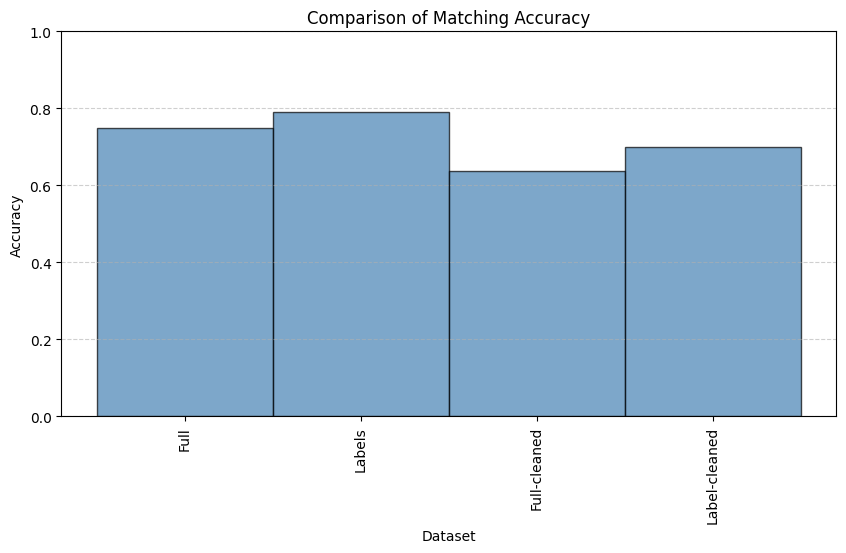

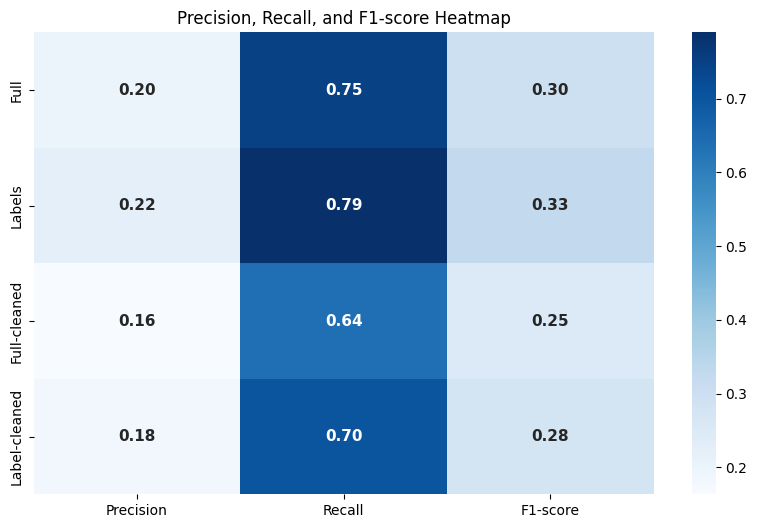

,Precision,Recall,F1-score,Threshold,Skills-count,Matched,Accuracy,Avg-Score
Full,0.197944,0.750000,0.296111,0.6,1319,225 / 300,0.750000,0.1891
Labels,0.224222,0.790000,0.325778,0.6,1286,237 / 300,0.790000,0.2043
Full-cleaned,0.163556,0.636667,0.250667,0.6,1286,191 / 300,0.636667,0.1609
Label-cleaned,0.184167,0.700000,0.277222,0.6,1287,210 / 300,0.700000,0.1797


In [21]:
plot_histogram(res_df)
print("")
plot_heatmap(res_df)
print("")
res_df